# Mark rooftops with u-net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [113]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam

import keras.backend as K

### Load data

In [101]:
X = np.load("roofs_w_unet/X_data.npy")
y = np.load("roofs_w_unet/y_data.npy")

#X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [94]:
X.shape

(50, 64, 64, 100)

### Make u net

In [4]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model



def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[49 48 14 46 44]


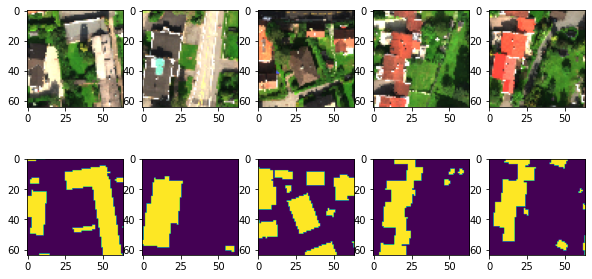

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (10,5))

indx = np.random.randint(0,high=X.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X[indx[i]][:,:,76],
                              X[indx[i]][:,:,46],
                              X[indx[i]][:,:,21])))
    ax[1,i].imshow(y[indx[i]][:,:,0])
plt.show()

### Set up u net

In [118]:
input_img = Input(shape=(64,64,100))
uu = get_unet(input_img, n_classes=1)

uu.compile(optimizer=Adam(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy', get_f1])

In [119]:
h = uu.fit(X_train, y_train, 
           validation_data=(X_test,y_test), 
           batch_size=10,
           epochs=200)

Epoch 1/200
4/4 [==============================] - 5s 305ms/step - loss: 0.6192 - accuracy: 0.6337 - get_f1: 0.0000e+00 - val_loss: 5153976.0000 - val_accuracy: 0.0301 - val_get_f1: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 92ms/step - loss: 0.3438 - accuracy: 0.7993 - get_f1: 0.0000e+00 - val_loss: 74143656.0000 - val_accuracy: 0.0419 - val_get_f1: 0.0000e+00
Epoch 3/200
4/4 [==============================] - 0s 90ms/step - loss: 0.2163 - accuracy: 0.8034 - get_f1: 0.0000e+00 - val_loss: 282182848.0000 - val_accuracy: 0.2179 - val_get_f1: 0.0000e+00
Epoch 4/200
4/4 [==============================] - 0s 95ms/step - loss: 0.1517 - accuracy: 0.8041 - get_f1: 0.0000e+00 - val_loss: 26856948.0000 - val_accuracy: 0.4387 - val_get_f1: 0.0000e+00
Epoch 5/200
4/4 [==============================] - 0s 92ms/step - loss: 0.1106 - accuracy: 0.8043 - get_f1: 0.0000e+00 - val_loss: 2232194.5000 - val_accuracy: 0.5789 - val_get_f1: 0.0000e+00
Epoch 6/200
4/4 [==================

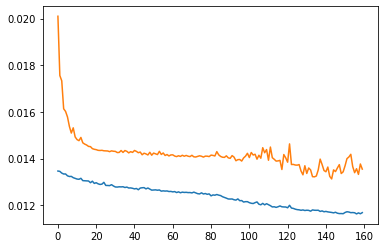

In [120]:
plt.plot(h.history['loss'][40:])
plt.plot(h.history['val_loss'][40:])

### Test prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted')

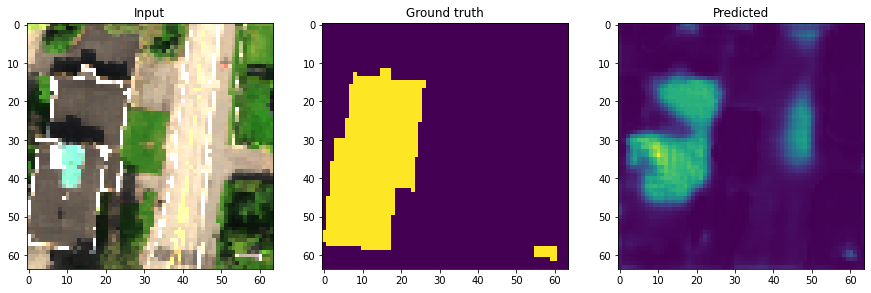

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
ax1.imshow(np.dstack((X_test[5:6][0][:,:,76],
                      X_test[5:6][0][:,:,46],
                      X_test[5:6][0][:,:,21])))
ax1.set_title("Input")
ax2.imshow(y_test[5:6][0][:,:,0])
ax2.set_title("Ground truth")
pred = uu.predict(X_test[5:6])[0][:,:,0]
ax3.imshow(pred)
ax3.set_title("Predicted")

In [57]:
a = pred.flatten()
a[a>.5] = 1
a[a<=.5] = 0
accuracy_score(y_test[5:6][0][:,:,0].flatten(), a)

ValueError: ignored

In [42]:
y_test[5:6][0][:,:,0].flatten().shape
pred.flatten().shape

(4096,)

In [55]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


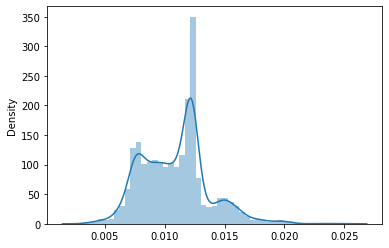

In [108]:
sns.distplot(pred)

In [78]:
!git pull


remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 7), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (14/14), done.
From https://github.com/stianteien/M_DV_V2022
   eeb0ae8..6497461  master     -> origin/master
Updating eeb0ae8..6497461
Checking out files: 100% (4/4), done.
Fast-forward
 roofs_w_unet/X_data.npy       |  Bin 2457728 -> 81920128 bytes
 roofs_w_unet/prepare_img.py   |   15 +-
 roofs_w_unet/roof_u-net.ipynb | 1697 +++++++++++++++++++++++++++++++++--------
 roofs_w_unet/y_data.npy       |  Bin 819328 -> 819328 bytes
 4 files changed, 1385 insertions(+), 327 deletions(-)
